In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Simple Recurrent Networks and temporal sequences 

Simple Recurrent Networks (SRN) are a class of networks that merge concepts of _feedforward networks_ and _recurrent networks_. Like feedforward networks, they typically have three "main" layers, and one specific direction in which activation flows. Unlike feedforward networks, they allow feedback connections between layers of neurons. Unlike recurrent networks, however, the feedback connections are not symmetric. The result of these constraints is a very particular architecture that deals with time series.  

## Elman's networks

There are multiple kinds of SRNs. The most common ones are Elman networks (Elman, 1990) and Jordan networks (Jordan, 1986). Here we will implement Elman's network. 

The network has four layers: 

1. The _input_ layer __x__
2. The _hidden_ layer __h__
3. The _output_ layer __o__
4. And a _context_ layer __u__.

The novelty, of course,is the presence of a context layer.

Here, we are going to define a basic SRN that performs a time series temporal version of the XOR problem.

### Network definition

Here are the variables that define the network's geometry.

In [178]:
n_x = 2
n_h = 5
n_o = 1
n_u = 5
eta = 0.75

### Implementation

To implement the network, we need to define the layers and the synpatic matrices, as well as specific functions to compute the network's activation and train the SNR. 

In [187]:
x = np.zeros((1, n_x))
h = np.zeros((1, n_h))
o = np.zeros((1, n_o))
u = np.zeros((1, n_u))

w_xh = np.random.random((n_x, n_h))
w_ho = np.random.random((n_h, n_o))
w_uh = np.random.random((n_u, n_h))


def logistic(x, deriv = False):
    """Sigmoid logistic function (with derivative)"""
    if deriv:
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))

    
    
def activation():
    """Spreads activation through a network"""
    global h, u, o
    
    # First pass, from input to hidden layer
    h_input = np.dot(x, w_xh) + np.dot(u, w_uh)
    h = logistic(h_input)
    
    # Second pass, from input layer to output
    output_input = np.dot(h, w_ho)
    o = logistic(output_input)
    
    # Prepare for next input
    u = np.copy(h)
    

def error(i, response):
    """Calculates the error function"""
    return 0.5 * np.sum((target(i) - response) ** 2)

    
def backprop(n = 1):
    """Performs the backpropagation algorithm over N epochs, returns error function"""
    E = []
    global w_xh, w_ho, w_uh 
    for i in np.arange(n):
        e = 0.0

        for p in patterns:
            set_inputs(p)
            activation()
            e += error(p, o)
            
            # Error in output layer
            o_error = target(p) - o
            do = o_error * logistic(o, deriv = True)
            
            # error in hidden layer
            h_error = np.dot(do, w_ho.T) 
            dh = h_error * logistic(h, deriv = True)
            
            # If you had other layers, we could go on and on...
            
            dw_ho = np.dot(h.T, do) 
            dw_xh = np.dot(x.T, dh)
            dw_uh = np.dot(u.T, dh)
            
            w_ho += eta * dw_ho
            w_xh += eta * dw_xh
            w_uh += eta * dw_uh
        
        E.append(np.asscalar(e))  # Error at epoch i 
    return E  # Returns the list of error by epoch
            


### Learning the temporal XOR

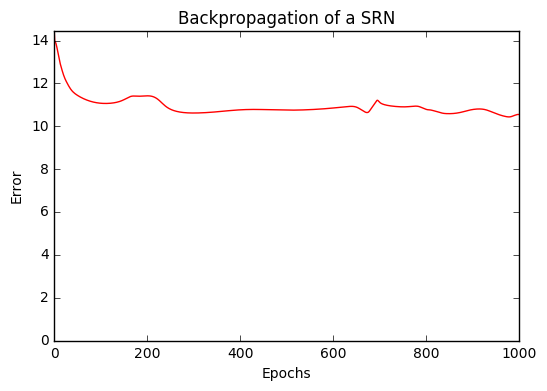

In [180]:
sequence = [np.round(np.random.random()) for i in range(100)]
def xor(a, b):
    if a != b:
        return 1
    else:
        return 0

for i in range(len(sequence)):
    if (i + 1) % 3 == 0:
        sequence[i] = xor(sequence[i-1], sequence[i-2])
        

def set_inputs(pos):
    """Sets a given XOR pattern into the input value"""
    global x
    vals = [sequence[pos-2], sequence[pos-1]]
    x = np.array(vals).reshape((1,2))

def target(pos):
    """Desired response function for an element of a sequence at position 'pos'"""
    return np.array([[sequence[pos]]])

#patterns = np.arange(2, 100, 3)
patterns = np.arange(2, 100, 1)

E = backprop(1000)
plt.plot(E, "r-")
plt.title("Backpropagation of a SRN")
plt.axis([0, len(E), 0, np.max(E)])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

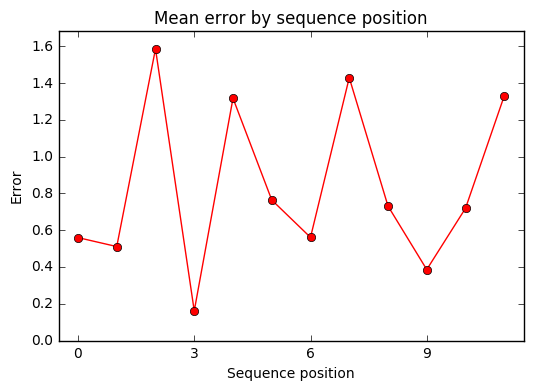

In [181]:
## Examine WHERE the errors are!

Z = []

for p in patterns:
    set_inputs(p)
    activation()
    Z.append(error(p, o))

Z = np.array(Z[0:96])
Z = Z.reshape((8, 12))
Z = np.sum(Z, axis=0).tolist()

plt.plot(Z, 'ro-')
plt.title("Mean error by sequence position")
plt.axis([-0.5, len(Z) - 0.5, 0, np.max(Z) + 0.1])
plt.xlabel("Sequence position")
plt.xticks(np.arange(0, 12, 3), np.arange(0, 12, 3))
plt.ylabel("Error")
plt.show()

## Isolating words

The Elman network can isolate words in continuous sentences. To show this, we will first generate a mini-grammar: 

In [290]:
# Generate sentences
import random

article = ['the', 'one']
adjective = ['good', 'bad', 'funny']
noun = ['boy', 'dog', 'girl', 'cat']
verb = ['loves', 'hates', 'kicks']



lexicon = {'ARTICLE' : article,
           'ADJECTIVE' : adjective,
           'NOUN' : noun,
           'VERB' : verb}

structures = [
    ['ARTICLE', 'NOUN', 'VERB', 'ARTICLE', 'NOUN'],
    ['ARTICLE', 'ADJECTIVE', 'NOUN', 'VERB'],
    ['ARTICLE', 'ADJECTIVE', 'NOUN', 'VERB', 'ARTICLE', 'NOUN'],
    ['ARTICLE', 'ADJECTIVE', 'NOUN', 'VERB', 'ARTICLE', 'ADJECTIVE', 'NOUN'],
             ] 

def create_sentences(n, structure):
    S = []
    for i in range(n):
        s = ""
        for category in structure:
            word = random.choice(lexicon[category])
            s += word
        S.append(s)
    return S

def create_all_sentences(n):
    S = []
    for struct in structures:
        S += create_sentences(n, struct)
    return S

The inputs of the network are single letters. Each letter is encoded as 5-bit pattern.  

In [291]:
import itertools

words = article + adjective + noun + verb

letter = ""
for w in words:
    letter += w
letters = set(letter)

binary = list(itertools.product([0, 1], repeat=5))

letter_code = dict(zip(letters, binary[0:len(letters)]))


Now we can expose our network to the continuous sentences.

In [292]:
n_x = 5
n_h = 20
n_o = 5
n_u = 20
eta = 0.5

S = create_all_sentences(20)
sequence = ""
for s in S:
    sequence += s

def set_inputs(pos):
    """Sets a given ltter pattern into the input value"""
    global x
    lttr = letter_code[sequence[pos]]
    x = np.array([lttr])

def target(pos):
    """Desired response function for an element of a sequence at position 'pos'"""
    return np.array([letter_code[sequence[pos + 1]]])

patterns = np.arange(0, len(sequence) - 1, 1)


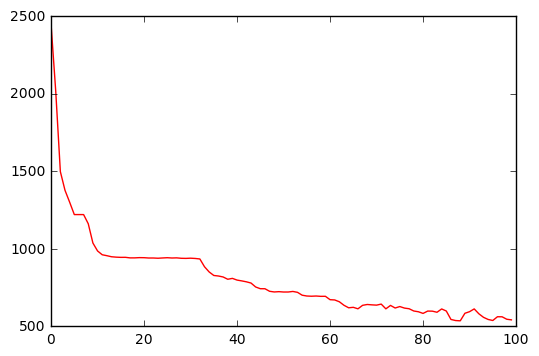

In [294]:
x = np.zeros((1, n_x))
h = np.zeros((1, n_h))
o = np.zeros((1, n_o))
u = np.zeros((1, n_u))
eta = 0.6
w_xh = np.random.random((n_x, n_h))
w_ho = np.random.random((n_h, n_o))
w_uh = np.random.random((n_u, n_h))

E = backprop(100)
plt.plot(E, 'r-')
plt.show()

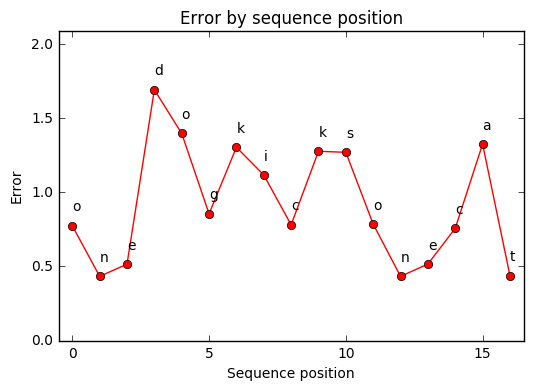

In [307]:
# Show the errors for a single sentence
Err = []
for l in np.arange(299, 316, 1):
    set_inputs(l)
    activation()
    Err.append(error(p, o))

plt.plot(Err, 'ro-')
plt.title("Error by sequence position")
plt.axis([-0.5, len(Err) - 0.5, 0, np.max(Err) + 0.4])
plt.xlabel("Sequence position")
for i in range(len(Err)):
    plt.text(i, Err[i] + 0.1, sequence[299 + i])
plt.ylabel("Error")
plt.show()